# Simple MBS Duration Trend

In [1]:
import os
import pulp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

The previous notebook examined a simplified Treasury Trend following as the hedge component of MBS Basis. The optimization did not consider the duration component of the MBS, which is important since the portfolio is a duration hedge MBS basis. This notebook will examine hedge the MBS basis by finding the optimal Treasury short position considering both the trend and the duration

In [2]:
def get_mbs_data() -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    mbs_path = os.path.join(data_path, "MBS.parquet")

    renamer = {
        "LUMSMD": "MBS_mod_dur",
        "LUMSOAS": "MBS_oas",
        "LUMSTRUU": "MBS_index"}

    df_mbs = (pd.read_parquet(
        path = mbs_path, engine = "pyarrow").
        rename(columns = renamer).
        reset_index().
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        set_index("date"))
    
    return df_mbs

df_mbs = get_mbs_data()

In [3]:
def get_tsy_data() -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    tsy_path = os.path.join(data_path, "tsy.parquet")

    df_tsy = (pd.read_parquet(
        path = tsy_path, engine = "pyarrow").
        rename(columns = {
            "CONVENTIONAL_CTD_FORWARD_FRSK": "ctd_duration",
            "FUT_EQV_CNVX_NOTL": "ctd_convexity"}).
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        set_index("date"))
    
    return df_tsy

df_tsy = get_tsy_data()

In [4]:
def get_treasury_trend() -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    path = os.path.join(data_path, "TreasuryTrend.parquet")
    df = pd.read_parquet(path = path, engine = "pyarrow")
    
    return df

df_trend = get_treasury_trend()

Still using the average trend of the lookbacks of the portfolio

In [5]:
def get_avg_trend(df_trend: pd.DataFrame) -> pd.DataFrame: 
    
    df_avg_trend = (df_trend.drop(
        columns = ["signal", "short_window", "long_window", "PX_LAST"]).
        groupby(["security", "date"]).
        agg("mean").
        reset_index())
    
    return df_avg_trend

df_avg_trend = get_avg_trend(df_trend)

The overall goal is to add the constraint into the optimization process

\begin{equation}
\min_{dur} ||CTA_{dur} - MBS_{dur}||^2 
\end{equation}

The overall goal is to loop through and find the optimal security, therefore the final step will be to <br>

\begin{equation}
\min \left(signal_1, signal_2, ... \right)
\end{equation}

Therefore the signals need to be modified as so

\begin{equation}
dur\; signal = 
\begin{cases}
signal < 0 &  \frac{signal}{(MBS_{dur} - CTA_{dur})^2}  \\
signal > 0 & signal \cdot (MBS_{dur} - CTA_{dur}) ^ 2
\end{cases}
\end{equation}

The easy way to think about this is that <br>
1. When the signal is negative and the duration difference is small the signal gets modified such that its absolute value becomes greater (in this case it will be a large negative number)
2. When the signal is positive and the duration difference is small teh signal gets modified such that the signal is smaller when the durations are closer

In [6]:
def get_lag_dur_signal(df_tsy: pd.DataFrame, df_mbs: pd.DataFrame, df_avg_trend: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_tsy.merge(
        right = df_mbs, how = "inner", on = ["date"]).
        assign(duration_diff = lambda x: (x.MBS_mod_dur - x.ctd_duration) ** 2)
        [["security", "duration_diff"]].
        reset_index().
        pivot(index = "date", columns = "security", values = "duration_diff").
        shift().
        reset_index().
        melt(id_vars = "date").
        dropna().
        rename(columns = {"value": "lag_dur_diff"}).
        merge(right = df_avg_trend, how = "inner", on = ["date", "security"]).
        assign(lag_dur_signal = lambda x: np.where(x.lag_signal < 0, x.lag_signal / x.lag_dur_diff, x.lag_signal * x.lag_dur_diff)))
    
    return df_out

df_lag_dur_signal = get_lag_dur_signal(df_tsy, df_mbs, df_avg_trend)

Now minimize the signal per every time step

In [7]:
def _minimize_signal(df: pd.DataFrame) -> pd.DataFrame: 
    return(df.query(
        "lag_dur_signal == lag_dur_signal.min()"))

def minimize_signal(df_lag_dur_signal: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_lag_dur_signal.drop(
        columns = ["lag_dur_diff", "lag_signal"]).
        groupby("date").
        apply(_minimize_signal).
        reset_index(drop = True))
    
    return df_out

df_min_signal = minimize_signal(df_lag_dur_signal)

In [8]:
def compare_cta_mbs_duration(
    df_min_signal: pd.DataFrame, 
    df_tsy: pd.DataFrame, 
    df_mbs: pd.DataFrame) -> pd.DataFrame: 
    
    df_combined = (df_min_signal.drop(
        columns = ["lag_dur_signal"]).
        merge(right = df_tsy, how = "inner", on = ["date", "security"]).
        merge(right = df_mbs, how = "inner", on = ["date"])
        [["date", "ctd_duration", "MBS_mod_dur"]].
        rename(columns = {
            "ctd_duration": "CTA Duration",
            "MBS_mod_dur": "MBS Duration"}).
        set_index("date"))
    
    return df_combined

df_compare_duration = compare_cta_mbs_duration(df_min_signal, df_tsy, df_mbs)

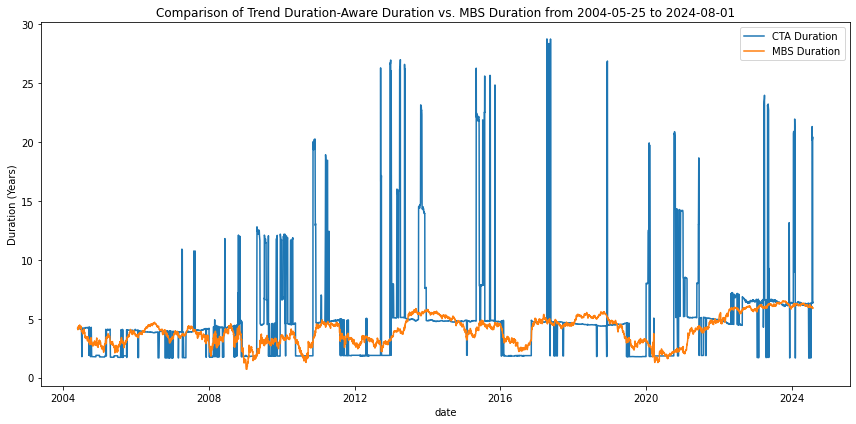

In [9]:
def plot_duration_comparison(df_compare_duration: pd.DataFrame) -> pd.DataFrame: 
    
    df_compare_duration.plot(
        figsize = (12,6),
        ylabel = "Duration (Years)",
        title = "Comparison of Trend Duration-Aware Duration vs. MBS Duration from {} to {}".format(
            df_compare_duration.index.min(),
            df_compare_duration.index.max()))
    
    plt.tight_layout()
    
plot_duration_comparison(df_compare_duration)

Although it looks very bumpy the CTA duration-aware signal matches the duration much better than the duration of the signal in the previous notebook. 

In [10]:
def get_treasury_returns(df_tsy: pd.DataFrame) -> pd.DataFrame: 
    
    df_tsy_rtn = (df_tsy.reset_index()[
        ["date", "security", "PX_LAST"]].
        pivot(index = "date", columns = "security", values = "PX_LAST").
        sort_index().
        pct_change())
    
    return df_tsy_rtn

df_tsy_rtn = get_treasury_returns(df_tsy)

In [11]:
def _get_bps(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_index().assign(
        bps = lambda x: x.PX_LAST.diff() / x.ctd_duration))

def get_bps(df_tsy: pd.DataFrame) -> pd.DataFrame: 

    df_bps = (df_tsy.groupby(
        "security").
        apply(_get_bps).
        drop(columns = ["security"]).
        reset_index()
        [["security", "date", "bps"]].
        pivot(index = "date", columns = "security", values = "bps"))
    
    return df_bps

df_tsy_bps = get_bps(df_tsy)

In [12]:
def get_signal_rtn(df_tsy_rtn: pd.DataFrame, df_min_signal: pd.DataFrame) -> pd.DataFrame: 
    
    df_longer = (df_tsy_rtn.reset_index().melt(
        id_vars = "date").
        rename(columns = {"value": "rtn"}))

    df_signal = (df_min_signal.merge(
        right = df_longer, how = "inner", on = ["date", "security"]).
        rename(columns = {"rtn": "signal"})
        [["date", "signal"]])

    df_out = (df_tsy_rtn.merge(
        right = df_signal, how = "inner", on = ["date"]).
        set_index("date").
        sort_index())
    
    return df_out

df_signal_rtn = get_signal_rtn(df_tsy_rtn, df_min_signal)

In [13]:
def get_signal_bps(df_tsy_bps: pd.DataFrame, df_min_signal: pd.DataFrame) -> pd.DataFrame: 
    
    df_signal_bps = (df_tsy_bps.reset_index().melt(
        id_vars = "date").
        merge(right = df_min_signal, how = "inner", on = ["date", "security"]).
        drop(columns = ["lag_dur_signal", "security"]).
        rename(columns = {"value": "signal"}).
        merge(right = df_tsy_bps, how = "inner", on = ["date"]).
        set_index("date").
        sort_index())
    
    return df_signal_bps

df_signal_bps = get_signal_bps(df_tsy_bps, df_min_signal)

In [14]:
def prep_full_rtn(df_signal_rtn: pd.DataFrame, df_signal_bps: pd.DataFrame) -> tuple:
    
    df_full_rtn = (df_signal_rtn.apply(
        lambda x: -1 * x).
        apply(lambda x: np.cumprod(1 + x) - 1))

    df_partial_rtn = (df_signal_rtn.dropna().apply(
        lambda x: -1 * x).
        apply(lambda x: np.cumprod(1 + x) - 1))

    df_full_bps = (df_signal_bps.apply(
        lambda x: -1 * x).
        apply(lambda x: np.cumsum(x)))

    df_partial_bps = (df_signal_bps.dropna().apply(
        lambda x: -1 * x).
        apply(lambda x: np.cumsum(x)))
    
    return df_full_rtn, df_partial_rtn, df_full_bps, df_partial_bps

In [15]:
def _plot_rtn(df: pd.DataFrame, title: str, ax):
    
    (df.drop(
        columns = ["signal"]).
        plot(
            ax = ax,
            color = "orange",
            alpha = 0.7))
    
    (df[
        ["signal"]].
        plot(
            ylabel = title,
            ax = ax,
            color = "blue",
            title = "Cumulative {} From {} to {}".format(
                title,
                df.index.min(),
                df.index.max())))

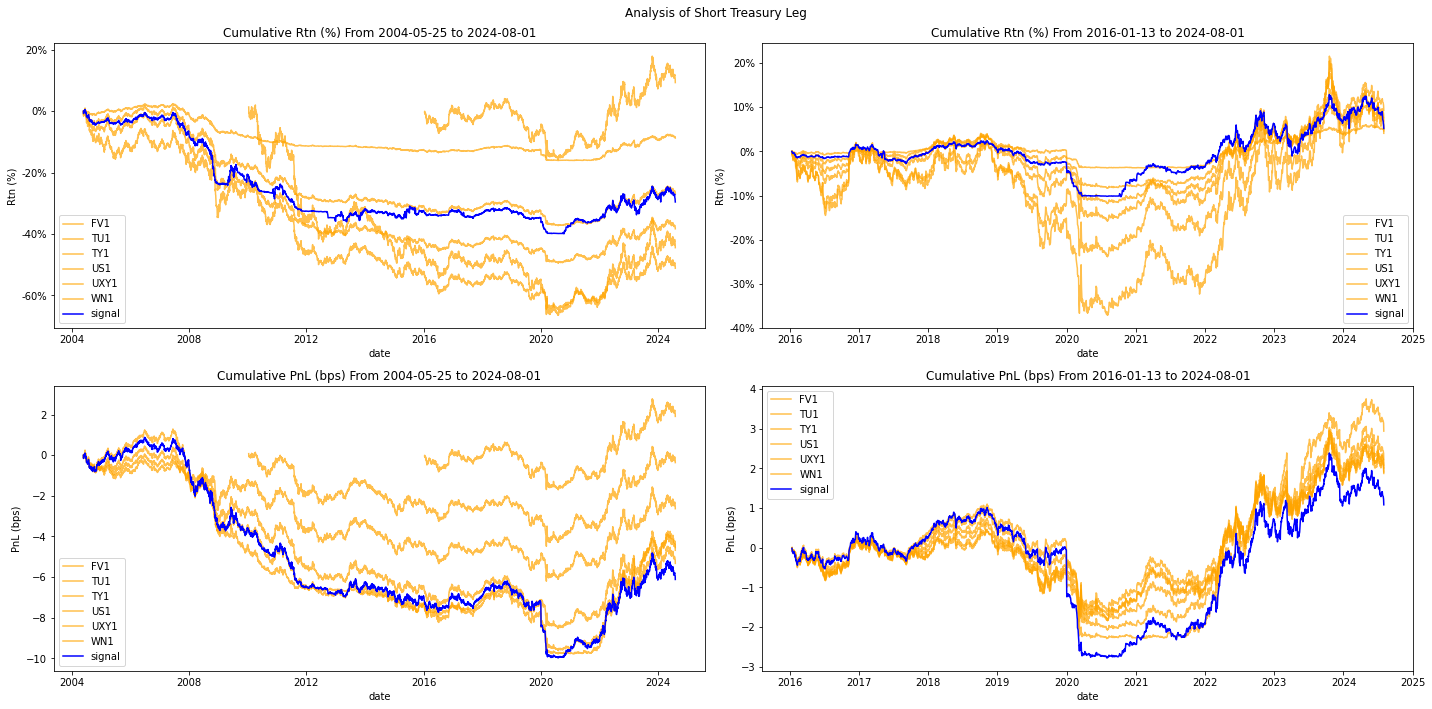

In [16]:
def plot_returns(df_signal_rtn: pd.DataFrame, df_signal_bps: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20,10))

    df_full_rtn, df_partial_rtn, df_full_bps, df_partial_bps = prep_full_rtn(df_signal_rtn, df_signal_bps)
    _plot_rtn(df_full_rtn, "Rtn (%)", axes[0,0])
    _plot_rtn(df_partial_rtn, "Rtn (%)", axes[0,1])
    _plot_rtn(df_full_bps, "PnL (bps)", axes[1,0])
    _plot_rtn(df_partial_bps, "PnL (bps)", axes[1,1])

    axes[0,0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    axes[0,1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    fig.suptitle("Analysis of Short Treasury Leg")
    plt.tight_layout()
    
plot_returns(df_signal_rtn, df_signal_bps)

Now apply the optimization to duration hedge the signal and analyze the returns

In [17]:
def _hedge_basis(df_tsy: pd.DataFrame, df_mbs: pd.DataFrame, df_min_signal: pd.DataFrame) -> pd.DataFrame: 
    
    df_tsy_lag_duration = (df_tsy[
        ["ctd_duration", "security"]].
        reset_index().
        pivot(index = "date", columns = "security", values = "ctd_duration").
        sort_index().
        shift().
        reset_index().
        melt(id_vars = "date").
        dropna())

    df_combined = (df_mbs.sort_index()[
        ["MBS_mod_dur"]].
        shift().
        dropna().
        merge(right = df_min_signal, how = "inner", on = ["date"]).
        drop(columns = ["lag_dur_signal"]).
        merge(right = df_tsy_lag_duration, how = "inner", on = ["date", "security"]).
        rename(columns = {
            "MBS_mod_dur": "mbs_duration",
            "value": "tsy_duration"}).
        set_index("date").
        sort_index())

    mbs_weights, tsy_weights = [], []
    for i, row in df_combined.iterrows():

        duration_problem = pulp.LpProblem(name = "duration_problem", sense = pulp.LpMinimize)
        mbs_weight = pulp.LpVariable(name = "mbs_weight", lowBound = 0.01, upBound = 1)
        tsy_weight = pulp.LpVariable(name = "tsy_weight", lowBound = 0.01, upBound = 1)

        duration_problem += (mbs_weight * row.to_dict()["mbs_duration"]) - (tsy_weight * row.to_dict()["tsy_duration"]) == 0
        duration_problem += mbs_weight + tsy_weight == 1

        solve = duration_problem.solve()
        mbs_weights.append(pulp.value(mbs_weight))
        tsy_weights.append(pulp.value(tsy_weight))   

    df_out = (df_combined.assign(
        mbs_weight = mbs_weights,
        tsy_weight = tsy_weights).
        drop(columns = ["tsy_duration", "mbs_duration"]))
    
    return df_out

In [18]:
def hedge_basis(
    df_tsy: pd.DataFrame, 
    df_mbs: pd.DataFrame, 
    df_min_signal: pd.DataFrame) -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    file_path = os.path.join(data_path, "AvgTrendDurationBasis.parquet")
    try:

        df = pd.read_parquet(path = file_path, engine = "pyarrow")

    except:

        df = _hedge_basis(df_tsy, df_mbs, df_min_signal)
        df.to_parquet(path = file_path, engine = "pyarrow")
       
    return df
    
df_weighting = hedge_basis(df_tsy, df_mbs, df_min_signal)

In [19]:
def get_basis_rtn(
    df_tsy_rtn: pd.DataFrame, 
    df_min_signal: pd.DataFrame, 
    df_mbs: pd.DataFrame) -> pd.DataFrame: 

    df_basis_rtn = (df_tsy_rtn.reset_index().melt(
        id_vars = "date").
        merge(right = df_min_signal, how = "inner", on = ["date", "security"]).
        drop(columns = ["lag_dur_signal"]).
        rename(columns = {"value": "tsy_rtn"}).
        merge(right = df_weighting, how = "inner", on = ["date", "security"]).
        merge(right = df_mbs, how = "inner", on = ["date"]).
        sort_values("date").
        assign(
            mbs_rtn = lambda x: x.MBS_index.pct_change(),
            basis_rtn = lambda x: (x.mbs_rtn * x.mbs_weight) - (x.tsy_rtn * x.tsy_weight))
        [["date", "security", "basis_rtn"]])
    
    return df_basis_rtn

df_basis_rtn = get_basis_rtn(df_tsy_rtn, df_min_signal, df_mbs)

In [20]:
def get_generic_basis(df_mbs: pd.DataFrame, df_tsy: pd.DataFrame) -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    weight_path = os.path.join(data_path, "DurationWeights.parquet")

    df_weight_prep = (pd.read_parquet(
        path = weight_path, engine = "pyarrow")
        [["security", "date", "lag_mbs_weight", "lag_tsy_weight"]].
        dropna())

    df_mbs_rtn = (df_mbs.sort_index().assign(
        mbs_rtn = lambda x: x.MBS_index.pct_change())
        [["mbs_rtn"]])

    df_tsy_rtn = (df_tsy[
        ["security", "PX_LAST"]].
        reset_index().
        pivot(index = "date", columns = "security", values = "PX_LAST").
        pct_change().
        reset_index().
        melt(id_vars = "date").
        rename(columns = {"value": "tsy_rtn"}).
        dropna())
    
    df_basis_rtn = (df_weight_prep.merge(
        right = df_mbs_rtn, how = "inner", on = ["date"]).
        merge(right = df_tsy_rtn, how = "inner", on = ["date", "security"]).
        assign(basis_rtn = lambda x: (x.mbs_rtn * x.lag_mbs_weight) - (x.tsy_rtn * x.lag_tsy_weight))
        [["security", "date", "basis_rtn"]].
        pivot(index = "date", columns = "security", values = "basis_rtn"))
    
    return df_basis_rtn

df_basis = get_generic_basis(df_mbs, df_tsy)

In [21]:
def combine_signals(df_basis_rtn: pd.DataFrame, df_basis: pd.DataFrame) -> pd.DataFrame: 
    
    df_signal = (df_basis_rtn.rename(
        columns = {"basis_rtn": "signal"}).
        drop(columns = ["security"]).
        set_index("date").
        sort_index())

    df_combined = (df_basis.merge(
        right = df_signal, how = "inner", on = ["date"]))
    
    return df_combined

df_combined_basis = combine_signals(df_basis_rtn, df_basis)

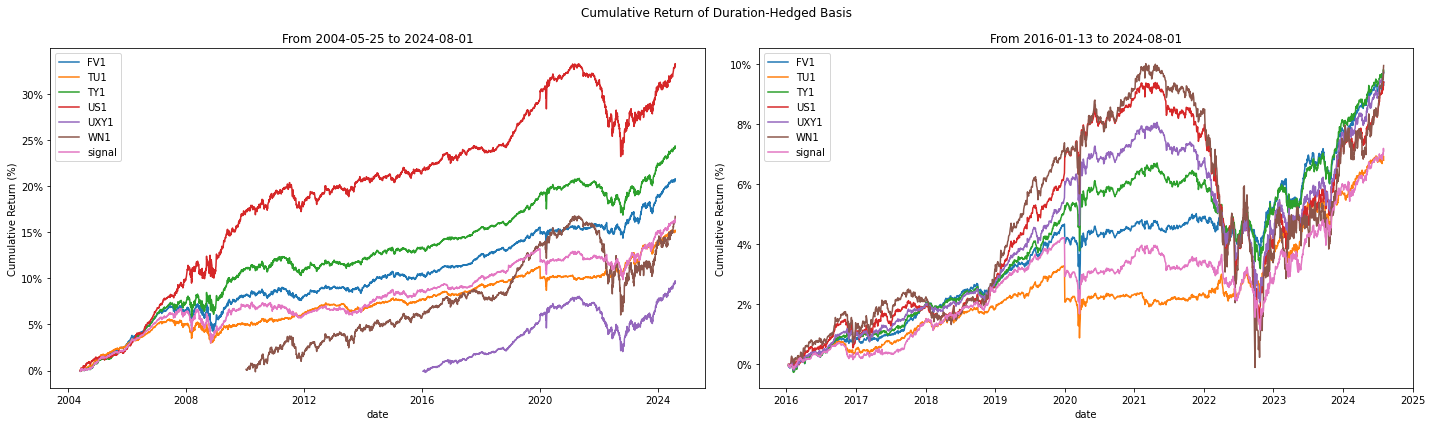

In [22]:
def plot_basis_rtn(df_combined_basis: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_combined_basis.apply(
        lambda x: np.cumprod(1 + x) - 1).
        plot(
            ylabel = "Cumulative Return (%)",
            ax = axes[0],
            title = "From {} to {}".format(
                df_combined_basis.index.min(),
                df_combined_basis.index.max())))

    (df_combined_basis.dropna().apply(
        lambda x: np.cumprod(1 + x) - 1).
        plot(
            ylabel = "Cumulative Return (%)",
            ax = axes[1],
            title = "From {} to {}".format(
                df_combined_basis.dropna().index.min(),
                df_combined_basis.index.max())))

    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))

    fig.suptitle("Cumulative Return of Duration-Hedged Basis")
    plt.tight_layout()
    
plot_basis_rtn(df_combined_basis)

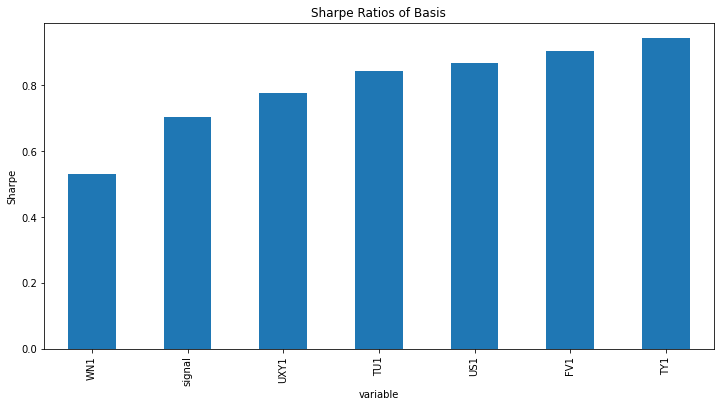

In [36]:
def plot_sharpes(df_combined_basis: pd.DataFrame) -> plt.Figure: 
    
    (df_combined_basis.reset_index().melt(
        id_vars = "date").
        drop(columns = ["date"]).
        groupby("variable").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std": "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        sort_values("sharpe").
        plot(
            figsize = (12,6),
            kind = "bar",
            legend = False,
            title = "Sharpe Ratios of Basis",
            ylabel = "Sharpe"))

plot_sharpes(df_combined_basis)